In [1]:
# Import necessary libraries
import math
import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors

import tifffile
import os
import re
from pathlib import Path

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import seaborn as sns
import plotly.graph_objects as go

In [2]:
# Calculate distances between the union of k nearest neighbor effectors to targets, k nearest neighbor targets to effectors
def bidirectional_knn_distances(target_path, effector_path, output_folder, k=50):
    '''
    Parameters: target_spots path
                effector_spots path
                path to where the distance matrices is to be saved
                number of nearest neighbors to include
    
    Returns: pivoted distance master file
    '''
    # Load spots.csv files
    target_df = pd.read_csv(target_path)
    effector_df = pd.read_csv(effector_path)
    effector_df.drop([0,1,2], axis=0, inplace=True) # Remove duplicated column names in from TrackMate's output
    effector_df = effector_df.reset_index()

    # Cleanup data
    target_df['POSITION_X'] = pd.to_numeric(target_df['POSITION_X'], errors='coerce')
    target_df['POSITION_Y'] = pd.to_numeric(target_df['POSITION_Y'], errors='coerce')
    target_df['TRACK_ID'] = pd.to_numeric(target_df['TRACK_ID'], errors='coerce')
    target_df['FRAME'] = pd.to_numeric(target_df['FRAME'], errors='coerce')

    effector_df['POSITION_X'] = pd.to_numeric(effector_df['POSITION_X'], errors='coerce')
    effector_df['POSITION_Y'] = pd.to_numeric(effector_df['POSITION_Y'], errors='coerce')
    effector_df['TRACK_ID'] = pd.to_numeric(effector_df['TRACK_ID'], errors='coerce')
    effector_df['FRAME'] = pd.to_numeric(effector_df['FRAME'], errors='coerce')

    # Drop rows where conversion failed (i.e., invalid entries became NaN)
    target_df.dropna(subset=['POSITION_X', 'POSITION_Y', 'TRACK_ID', 'FRAME'], inplace=True)
    effector_df.dropna(subset=['POSITION_X', 'POSITION_Y', 'TRACK_ID', 'FRAME'], inplace=True)
    
    sample_idx = re.findall(r'xy(\d+)', output_folder) # for naming output files
    
    all_distances = []

    for frame in sorted(set(target_df['FRAME']).intersection(set(effector_df['FRAME']))):
        target_frame = target_df[target_df['FRAME'] == frame]
        effector_frame = effector_df[effector_df['FRAME'] == frame]

        target_coords = target_frame[['POSITION_X', 'POSITION_Y']].values
        effector_coords = effector_frame[['POSITION_X', 'POSITION_Y']].values
        target_ids = target_frame['TRACK_ID'].values
        effector_ids = effector_frame['TRACK_ID'].values

        if len(target_coords) == 0 or len(effector_coords) == 0:
            continue

        # Target to Effector
        nbrs_t2e = NearestNeighbors(n_neighbors=min(k, len(effector_coords))).fit(effector_coords)
        distances_t2e, indices_t2e = nbrs_t2e.kneighbors(target_coords)
        for i, (dists, idxs) in enumerate(zip(distances_t2e, indices_t2e)):
            for dist, idx in zip(dists, idxs):
                all_distances.append({
                    'Frame': frame,
                    'target_ID': target_ids[i],
                    'effector_ID': effector_ids[idx],
                    'Distance': dist
                })

        # Effector to Target
        nbrs_e2t = NearestNeighbors(n_neighbors=min(k, len(target_coords))).fit(target_coords)
        distances_e2t, indices_e2t = nbrs_e2t.kneighbors(effector_coords)
        for i, (dists, idxs) in enumerate(zip(distances_e2t, indices_e2t)):
            for dist, idx in zip(dists, idxs):
                all_distances.append({
                    'Frame': frame,
                    'target_ID': target_ids[idx],
                    'effector_ID': effector_ids[i],
                    'Distance': dist
                })

    # Combine and remove duplicates (if any)
    distance_df = pd.DataFrame(all_distances).drop_duplicates()
    # Pivot the DataFrame for ease of downstream analysis
    distance_pivot_df = distance_df.pivot_table(index=['target_ID', 'effector_ID'], columns='Frame', values='Distance')
    # Save the pivoted DataFrame for visualization
    distance_pivot_df.to_csv(os.path.join(output_folder, f'xy{sample_idx[-1]}_pivoted_distances.csv'))
    
    return distance_pivot_df

In [3]:
# Filter distance_pivot_df such that pairs where there is no NaN in N+1 consecutive frames is being retained
def has_valid_consecutive_values(row, N):
    # Convert to boolean mask: True where value is not NaN
    not_nan = row.notna().values.astype(int)
    
    # Use convolution to find stretches of N+1 consecutive non-NaNs
    window = np.ones(N + 1, dtype=int)
    valid_runs = np.convolve(not_nan, window, mode='valid')
    
    return np.any(valid_runs == (N + 1))

def filter_pairs_with_consecutive_non_nan(df, N):
    # Apply the check row-wise
    return df[df.apply(lambda row: has_valid_consecutive_values(row, N), axis=1)]

In [4]:
# Merge overlapping or consecutive (Start_Frame, End_Frame) intervals for the same (target_ID, effector_ID) pair.
def merge_overlapping_intervals(df):
    merged_rows = []

    # Group by target_ID and effector_ID
    for (target_id, effector_id), group in df.groupby(['target_ID', 'effector_ID']):
        # Sort intervals by Start_Frame
        intervals = group.sort_values('Start_Frame')[['Start_Frame', 'End_Frame']].values

        # Merge overlapping or consecutive intervals
        merged = []
        current_start, current_end = intervals[0]
        for start, end in intervals[1:]:
            if start <= current_end + 1:  # overlap or consecutive
                current_end = max(current_end, end)
            else:
                merged.append((target_id, effector_id, current_start, current_end))
                current_start, current_end = start, end
        merged.append((target_id, effector_id, current_start, current_end))  # final one

        merged_rows.extend(merged)

    return pd.DataFrame(merged_rows, columns=['target_ID', 'effector_ID', 'Start_Frame', 'End_Frame'])

In [5]:
# Identify object pairs where the distance decreases over N consecutive frames
def find_approaching_pairs(distance_df, N, output_folder):
    '''
    Parameters: pivoted distance DataFrame, N number of consecutive frames, output folder path
    Returns: DataFrame with columns: target_ID, effector_ID, Start_Frame, End_Frame
    '''
    approaching_pairs = []
    sample_idx = re.findall(r'xy(\d+)', output_folder)

    # Filter data
    filtered = filter_pairs_with_consecutive_non_nan(distance_df, N)

    for (obj1, obj2), row in filtered.iterrows():
        data = row.values
        idxs = np.arange(len(data))
        # Build N-window "differences" matrix
        # Get all rolling windows of size N+1
        if len(data) < N+1 or np.sum(~np.isnan(data)) < N+1:
            continue
        sliding = np.lib.stride_tricks.sliding_window_view(data, N+1)
        valid = ~np.isnan(sliding).any(axis=1)
        diffs = np.diff(sliding, axis=1)
        # Each row: need all diffs negative (strictly decreasing)
        is_dec = (diffs < 0).all(axis=1)
        matches = np.where(valid & is_dec)[0]
        for m in matches:
            # The window starts at index m, ends at m+N
            start_frame = row.index[m]
            end_frame = row.index[m+N]
            approaching_pairs.append((obj1, obj2, start_frame, end_frame))

    # Save results to CSV
    result_df = pd.DataFrame(approaching_pairs,
                             columns=['target_ID', 'effector_ID', 'Start_Frame', 'End_Frame'])
    result_merged = merge_overlapping_intervals(result_df)
    result_merged.to_csv(os.path.join(output_folder, f'xy{sample_idx[-1]}_approaching_pairs.csv'), index=False)
    
    return result_df

In [6]:
# Identify object pairs where the distance stays below a threshold for N consecutive frames
def find_persistent_contact(distance_df, threshold, N, output_folder):
    '''
    Parameters: pivoted distance DataFrame, distance threshold, N number of consecutive frames, output folder path
    Returns: DataFrame with columns: target_ID, effector_ID, Start_Frame, End_Frame
    '''
    persistent_contact_pairs = []
    sample_idx = re.findall(r'xy(\d+)', output_folder)

    # Filter data
    filtered = filter_pairs_with_consecutive_non_nan(distance_df, N)

    for (obj1, obj2), row in filtered.iterrows():
        # row is a Series (frame-indexed)
        mask = row < threshold           # boolean mask: true where under threshold
        mask = mask & row.notna()        # only consider non-NaN
        # Rolling sum, window=N, tells you where there are N consecutive True
        roll = mask.rolling(window=N, min_periods=N).sum()
        hits = roll[roll == N]
        if not hits.empty:
            hit_idxs = list(hits.index)
            for end_frame in hit_idxs:
                start_frame = row.index[row.index.get_loc(end_frame) - N + 1]
                persistent_contact_pairs.append((obj1, obj2, start_frame, end_frame))

    # Save results to CSV
    result_df = pd.DataFrame(
        persistent_contact_pairs,
        columns=['target_ID', 'effector_ID', 'Start_Frame', 'End_Frame']
    )
    result_merged = merge_overlapping_intervals(result_df)
    result_merged.to_csv(os.path.join(output_folder, f'xy{sample_idx[-1]}_persistent_contact_pairs.csv'), index=False)
    
    return result_df

In [7]:
# Gets the final state and transition frame of cells
def get_terminal_state(target_df, state):
    '''
    Parameters: TrackMate spots csv file for target, terminal state (str or list of strs)
    Returns: DataFrame of TRACK_ID, SOURCE (last known SOURCE matches the given state(s)),  TRANSITION_FRAME (frame when the state changed)
    '''
    # Ensure 'FRAME' is integer
    target_df['FRAME'] = target_df['FRAME'].astype(int)

    # Sort to ensure correct order
    target_df = target_df.sort_values(['TRACK_ID', 'FRAME'])

    # Get the frame where there is a change in SOURCE
    def get_transition_frame(group):
        source_series = group['SOURCE'].reset_index(drop=True)
        frame_series = group['FRAME'].reset_index(drop=True)
    
        if (source_series == source_series.iloc[0]).all():
            return pd.Series({'TRANSITION_FRAME': pd.NA})
    
        for i in range(1, len(source_series)):
            if source_series.iloc[i] != source_series.iloc[i - 1]:
                return pd.Series({'TRANSITION_FRAME': frame_series.iloc[i]})

    # Apply get_transition_frame
    transition_df = target_df.groupby('TRACK_ID', group_keys=False).apply(get_transition_frame).reset_index()


    # Get terminal state at last frame
    terminal_df = target_df.sort_values('FRAME').groupby('TRACK_ID').last().reset_index()
    terminal_df = terminal_df[['TRACK_ID', 'SOURCE']].rename(columns={'SOURCE': 'TERMINAL_STATE'})

    # Filter terminal states
    if isinstance(state, list):
        terminal_state = terminal_df[terminal_df['TERMINAL_STATE'].isin(state)]
    else:
        terminal_state = terminal_df[terminal_df['TERMINAL_STATE'] == state]

    # Merge with transition frame info
    result_df = pd.merge(transition_df, terminal_state, on='TRACK_ID', how='left')

    return result_df

In [8]:
# Count the occurrences of: targets that appeared in the interaction (approaching or persistent) DataFrame, effectors that were paired with those targets
def count_occurrences(target_ids, interaction_df):
    '''
    Parameters: ID list of targets, interaction (approaching or persistent contact) DataFrame
    Returns: DataFrame with the number of occurrences for each given target ID  
    '''
    # Filter interaction_df for rows where 'target_ID' is in target_ids
    filtered_hits = interaction_df[interaction_df['target_ID'].isin(target_ids)]

    # Count occurrences of each target ID appears among those interactions
    target_occurrence_counts = filtered_hits['target_ID'].value_counts().reset_index()
    target_occurrence_counts.columns = ['target_ID', 'Occurrences']

    return target_occurrence_counts

In [9]:
# Individual sample DataFrame pre-processing for graphing
def indv_df_preprocessing(sample_idx, persistent_df, combined_persistent, metrics_df, combined_metrics, frame_interval=5, dead_only=False):
    # Persistent contact DataFrame pre-processing
    # Convert frame number to time
    frame_interval = 5
    persistent_df['Duration'] = (persistent_df['End_Frame'] - persistent_df['Start_Frame']) * frame_interval
    persistent_df['Start_Time'] = persistent_df['Start_Frame'] * frame_interval
    persistent_df['End_Time'] = persistent_df['End_Frame'] * frame_interval

    # Get terminal state (Live or Dead) of all targets
    all_targets = get_terminal_state(target_df, ['YFP', 'PI'])
    # Map terminal state into persistent interaction DataFrame
    id_to_state = all_targets.set_index("TRACK_ID")["TERMINAL_STATE"]
    persistent_df['Target_State'] = persistent_df['target_ID'].map(id_to_state)
    # Map transition frame into persistent interaction DataFrame
    id_to_transition = all_targets.set_index("TRACK_ID")["TRANSITION_FRAME"]
    persistent_df['Death_Frame'] = persistent_df['target_ID'].map(id_to_transition)
    persistent_df['Death_Time'] = persistent_df['Death_Frame'] * frame_interval
    
    # Count occurrences of all targets in persistent interaction DataFrame
    target_occurrences = count_occurrences(all_targets['TRACK_ID'], persistent_df)
    # Map number of occurrences into persistent interaction DataFrame
    id_to_count = target_occurrences.set_index("target_ID")["Occurrences"]
    # Assign the count to each row
    persistent_df['Interaction_Count'] = persistent_df['target_ID'].map(id_to_count)

    # Assign bins based on number of persistent contacts for each target
    bins = [0, 3, 6, 9, float('inf')]
    labels = ['1-3', '4-6', '6-9', '>9']
    persistent_df['Interaction_Group'] = pd.cut(persistent_df['Interaction_Count'], bins=bins, labels=labels)

    # Compute total interaction duration per target
    total_duration_df = (
        persistent_df.groupby("target_ID")["Duration"]
        .sum()
        .reset_index(name="Cumulative_Duration")
    )
    persistent_df = pd.merge(persistent_df, total_duration_df, on="target_ID")
    # Concatenate persistent_df for visualizing killing kinetics by sample
    persistent_df['Sample'] = f'xy{sample_idx[-1]}'
    combined_persistent.append(persistent_df)

    # Filter for dead cells only
    dead_persistent_df = persistent_df[persistent_df['Target_State'] == 'Dead']


    # Metrics DataFrame pre-processing
    # Add time info to metrics.df
    metrics_df['Time'] = metrics_df['FRAME'] * frame_interval
    
    # Filter for interacting cells only in metrics.df
    filtered_metrics_df = metrics_df[metrics_df['TRACK_ID'].isin(persistent_df['target_ID'].unique())].copy()
    
    # Extract Death_Time per target from persistent_df
    death_time_map = persistent_df[['target_ID', 'Death_Time']].dropna().drop_duplicates()
    id_to_death = dict(zip(death_time_map['target_ID'], death_time_map['Death_Time']))
    # Attach Death_Frame info to metrics_df
    filtered_metrics_df['Death_Time'] = filtered_metrics_df['TRACK_ID'].map(id_to_death)
    # Concatenate metrics_df for visualizing killing kinetics by sample
    filtered_metrics_df['Sample'] = f'xy{sample_idx[-1]}'
    combined_metrics.append(filtered_metrics_df)

    if dead_only:
        return dead_persistent_df, combined_persistent, filtered_metrics_df, combined_metrics
    else:
        return persistent_df, combined_persistent, filtered_metrics_df, combined_metrics

In [10]:
# Combined metrics DataFrame pre-processing for graphing:
def combined_df_preprocessing(combined_metrics, combined_persistent):
    combined_metrics_df = pd.concat(combined_metrics, ignore_index=True)
    combined_persistent_df = pd.concat(combined_persistent, ignore_index=True)
    combined_metrics_dying = combined_metrics_df.dropna(subset=['Death_Time']).copy()
    
    # Calculate time before death and area normalized to first appearance
    idx = combined_metrics_dying.groupby('TRACK_ID')['FRAME'].idxmin()
    first_areas = combined_metrics_dying.loc[idx].set_index('TRACK_ID')['area'].rename("first_area")
    combined_metrics_dying = combined_metrics_dying.merge(first_areas, on="TRACK_ID")
    combined_metrics_dying["norm_area"] = combined_metrics_dying["area"] / combined_metrics_dying["first_area"]
    combined_metrics_dying["time_to_death"] = combined_metrics_dying["Time"] - combined_metrics_dying["Death_Time"]

    return combined_metrics_df, combined_metrics_dying, combined_persistent_df

In [11]:
# Plot histograms of interactions count and interaction time distribution
def plot_histogram_interaction_distribution(sample_idx, persistent_df, fig_folder):
    fig, axes = plt.subplots(1, 3, figsize=(16, 6))
    # Plot 1
    # Manually set histogram bins and x-axis ticks
    max_target = max(persistent_df["Interaction_Count"].tolist())
    target_bins = np.arange(0.5, max_target + 1.5, 1)
    target_x_ticks = np.arange(1, max_target + 1)

    # Plot data
    sns.histplot(
        data=persistent_df, 
        x='Interaction_Count',
        hue="Target_State", 
        hue_order = ["YFP", "PI"],
        bins=target_bins, 
        color='steelblue', 
        ax=axes[0]
    )
    axes[0].set_title(f'xy{sample_idx} Persistent encountered before target death')
    axes[0].set_xlabel('Number of persistent contact')
    axes[0].set_ylabel('Number of Targets')
    axes[0].set_xticks(target_x_ticks)
    axes[0].yaxis.set_major_locator(MaxNLocator(integer=True)) # force y-axis ticks to be integers
    axes[0].grid(True, linestyle='--', alpha=0.4)
    state_legend = axes[0].get_legend()
    state_legend.set_title('State of Target')

    
    # Plot 2
    # Manually set histogram bins and x-axis ticks
    plot2_max_duration = persistent_df['Duration'].max()
    plot2_bin_edges = np.arange(0, plot2_max_duration + 5, 5)

    # Plot data
    sns.histplot(
        data=persistent_df, 
        x="Duration", 
        hue="Target_State", 
        hue_order = ["YFP", "PI"],
        bins=plot2_bin_edges,
        palette = "tab10", 
        element = "bars", # "bars" or "step"
        ax=axes[1]
    )
    axes[1].set_title(f"xy{sample_idx} Persitent Contact Duration by Target Fate")
    axes[1].set_xlabel("Persistent contact duration (minutes)")
    axes[1].set_xticks(np.arange(0, plot2_max_duration + 10, 10))
    axes[1].set_ylabel("Number of persistent contacts")
    axes[1].grid(axis='y', linestyle='--', alpha=0.6)
    state_legend = axes[1].get_legend()
    state_legend.set_title('State of Target')

    
    # Plot 3
    # Manually set histogram bins and x-axis ticks
    plot3_max_duration = persistent_df['Cumulative_Duration'].max()
    plot3_bin_edges = np.arange(0, plot3_max_duration + 20, 20)
    
    sns.histplot(
        data=persistent_df,
        x="Cumulative_Duration",
        hue="Interaction_Group",
        bins=plot3_bin_edges,
        multiple="stack",  # "stack" or "dodge" or "layer"
        kde = True,
        palette="Set2",
        edgecolor="black",
        ax = axes[2]
    )
    axes[2].set_title(f"xy{sample_idx} Cumulative Persistent Contact Duration Split by Number of Contacts per Target")
    axes[2].set_xlabel("Cumulative persistent contact duration (min)")
    axes[2].set_xticks(np.arange(0, plot3_max_duration + 50, 50))
    axes[2].set_ylabel("Number of persistent contacts")
    axes[2].grid(axis='y', linestyle='--', alpha=0.6)
    interaction_legend = axes[2].get_legend()
    interaction_legend.set_title('Persistent Contact per Target')

    plt.tight_layout()
    
    # Save figure
    fig_path = os.path.join(fig_folder, f"xy{sample_idx}_interaction_distribution_histograms.png")
    fig.savefig(fig_path, dpi=300, bbox_inches="tight")
    
    plt.show()

In [12]:
# Plot interaction count heatmap
def plot_interaction_heatmap(persistent_df, filtered_metrics_df, frame_interval=5, drop_step=0.3, panel_size=200):
    # Expand to per-frame interactions
    expanded = []
    
    for _, row in persistent_df.iterrows():
        for frame in range(row["Start_Frame"], row["End_Frame"] + 1):
            expanded.append({
                "target_ID": row["target_ID"],
                "Frame": frame,
                "effector_ID": row["effector_ID"],
            })
    
    expanded_df = pd.DataFrame(expanded)
    expanded_df['Time'] = expanded_df['Frame'] * frame_interval 
    
    # Count unique effectors per target per frame
    counts = (
        expanded_df.groupby(["target_ID", "Time"])["effector_ID"]
        .nunique()
        .reset_index(name="effector_count")
    )
    
    # Pivot into matrix (targets x time)
    heatmap_data = counts.pivot(index="target_ID", columns="Time", values="effector_count").fillna(0)
    
    # Sort target_IDs by death_frame
    sorted_targets = (
        persistent_df.groupby('target_ID')['Death_Time']
        .first()
        .sort_values(na_position='last')  # alive = NaN goes to bottom of sort
        .index[::-1]  # reverse so early deaths are at bottom (low y-index)
    )
    heatmap_data = heatmap_data.loc[sorted_targets]

    
    # Calculate area change
    # Prepare thresholds
    drop_thresholds = np.arange(1 - drop_step, 0, -drop_step)
    drop_thresholds = np.round(drop_thresholds, 2)

    # Compute relative area
    filtered_metrics_df = filtered_metrics_df.sort_values(["TRACK_ID", "FRAME"])
    first_areas = filtered_metrics_df.groupby("TRACK_ID")["area"].transform("first")
    filtered_metrics_df["Relative_Area"] = filtered_metrics_df["area"] / first_areas
    
    # Detect crossings
    area_drops = []
    
    for target_id, group in filtered_metrics_df.groupby("TRACK_ID"):
        seen_thresholds = set()
        for _, row in group.iterrows():
            for threshold in drop_thresholds:
                if row["Relative_Area"] <= threshold and threshold not in seen_thresholds:
                    area_drops.append({
                        "target_ID": target_id,
                        "Time": row["Time"],
                        "Threshold": threshold
                    })
                    seen_thresholds.add(threshold)
    
    area_drop_df = pd.DataFrame(area_drops)

    # Create color palette
    unique_thresholds = sorted(area_drop_df["Threshold"].unique(), reverse=True)
    palette = sns.color_palette("crest", n_colors=len(unique_thresholds))
    threshold_color_map = dict(zip(unique_thresholds, palette))
    
    
    # Plot heatmap (split into panels)
    # Specify intervals to split into
    total_targets = heatmap_data.shape[0]
    remainder = total_targets % panel_size
    
    split_indices = []
    if remainder > 0:
        split_indices.append((0, remainder))
    # Then add all the full-size chunks
    for i in range(remainder, total_targets, panel_size):
        split_indices.append((i, i + panel_size))

    for i, (start, end) in enumerate(split_indices):
        chunk = heatmap_data.iloc[start:end]
    
        # Plot each panel
        plt.figure(figsize=(14, 10))
        ax = sns.heatmap(
            chunk,
            cmap="Reds",
            cbar_kws={"label": "Number of Effectors"},
            xticklabels=10,
            yticklabels=False,
            linewidths=0.1
        )
    
        # Add marker for area drops and death times
        target_to_row = {target: i for i, target in enumerate(chunk.index)}
        
        area_drop_chunk = area_drop_df[area_drop_df["target_ID"].isin(chunk.index)].copy()
        
        deaths_in_chunk = persistent_df[
            persistent_df["target_ID"].isin(target_to_row) & 
            persistent_df["Death_Time"].notna()
        ]

        for threshold, color in threshold_color_map.items():
            threshold_subset = area_drop_chunk[area_drop_chunk["Threshold"] == threshold]
            for _, row in threshold_subset.iterrows():
                target = row["target_ID"]
                time = row["Time"] / frame_interval + 0.5
                y = target_to_row[target] + 0.5
                
                ax.plot(
                    time,
                    y,
                    marker="v",
                    linestyle="None",
                    color=color,
                    markersize=4,
                    label=f"{int((1 - threshold) * 100)}% drop"
                )
            
        for _, row in deaths_in_chunk.iterrows():
            target = row["target_ID"]
            death_time = row["Death_Time"] / frame_interval + 0.5
            y = target_to_row[target] + 0.5
            
            ax.plot(
                death_time, y,
                marker='v', color='black',
                markersize=5, label='Death Time' if 'Death Time' not in ax.get_legend_handles_labels()[1] else ""
            )
    
        plt.xlabel("Time (minutes)")
        plt.ylabel("Target")
        plt.title(f"Effector Interactions (Targets {start + 1}–{min(end, heatmap_data.shape[0])})")
        plt.tight_layout()
        plt.show()

In [13]:
# Plot metrics heatmap
def plot_metrics_heatmap(filtered_metrics_df, panel_size=500, metric='area'):
    # Sort metrics_df by death time (with alive cells on top)
    sort_order = (
        filtered_metrics_df.groupby('TRACK_ID')['Death_Time']
        .first()
        .sort_values(na_position='last')  # alive = NaN goes to bottom of sort
        .index[::-1]  # reverse so early deaths are at bottom (low y-index)
    )
    
    # Pivot data for heatmap
    heatmap_data = filtered_metrics_df.pivot(index='TRACK_ID', columns='Time', values=metric)
    heatmap_data = heatmap_data.loc[sort_order]
    # Normalize row-wise (per target)
    normalized_heatmap = heatmap_data.subtract(heatmap_data.min(axis=1), axis=0)
    normalized_heatmap = normalized_heatmap.divide(normalized_heatmap.max(axis=1), axis=0)
    
    # Plot heatmap (split into panels)
    # Specify intervals to split into
    total_targets = heatmap_data.shape[0]
    remainder = total_targets % panel_size
    
    split_indices = []
    if remainder > 0:
        split_indices.append((0, remainder))
    # Then add all the full-size chunks
    for i in range(remainder, total_targets, panel_size):
        split_indices.append((i, i + panel_size))

    for i, (start, end) in enumerate(split_indices):
        chunk = normalized_heatmap.iloc[start:end]
    
        # Plot each panel
        fig, ax = plt.subplots(figsize=(12, 8))
    
        sns.heatmap(
            chunk,
            cmap='inferno',
            cbar_kws={'label': 'Normalized'},
            xticklabels=10,
            yticklabels=False,
            ax=ax
        )

        # Plot styling
        ax.set_xlabel('Time (minutes)')
        ax.set_ylabel('Target Cells')
        ax.set_title(f"Normalized Target Cell Area Over Time (Targets {start + 1}–{min(end, heatmap_data.shape[0])})")
        plt.tight_layout()
        plt.show()

In [21]:
# Plot Sankey plot for state transitions
def plot_sankey(sample_idx, spots_df, area_df, fig_folder, shrink_threshold=0.7):
    '''
    Parameters: sample index
                spots_df (contains all tracks)
                area_df (contains area over time and death info only of target cells that interacted with effector cells)
    Returns: Sankey plot showing state transitions
    '''
    # Filter sample-specific data
    targets = set(spots_df['TRACK_ID'].unique())
    interacted = set(area_df['TRACK_ID'].unique())
    dead = set(area_df[area_df['Death_Time'].notna()]['TRACK_ID'])

    # Calculate first area per cell
    idx = area_df.groupby('TRACK_ID')['FRAME'].idxmin()
    first_area = area_df.loc[idx].set_index('TRACK_ID')['area'].rename("first_area")
    area_df = area_df.merge(first_area, on="TRACK_ID")

    # Minimum area per cell (to see if it ever dropped below threshold)
    min_area = area_df.groupby('TRACK_ID')['area'].min()
    dropped = set(min_area[min_area < (first_area * shrink_threshold)].index)

    # Categorize cells
    no_interaction = targets - interacted
    interaction_only = interacted - dropped
    shrinking = dropped
    dead_shrinking = shrinking & dead
    alive_shrinking = shrinking - dead

    # Define nodes and flows
    labels = [
        "All Targets",
        "No Interaction", "Interaction",
        "No Shrink", "Shrink",
        "Alive", "Dead"
    ]
    
    sources = [0, 0, 2, 2, 4, 4]  # From node index
    targets = [1, 2, 3, 4, 5, 6]  # To node index
    values = [
        len(no_interaction),
        len(interacted),
        len(interaction_only),
        len(shrinking),
        len(alive_shrinking),
        len(dead_shrinking)
    ]
    
    # Plot Sankey
    fig = go.Figure(data=[go.Sankey(
        node=dict(
            pad=15,
            thickness=20,
            line=dict(color="black", width=0.5),
            label=labels,
            color="lightgray"
        ),
        link=dict(
            source=sources,
            target=targets,
            value=values,
            color=["#a6cee3", "#1f78b4", "#b2df8a", "#33a02c", "#fb9a99", "#e31a1c"]
        )
    )])
    
    fig.update_layout(title_text=f"Target Cell Fate Transitions – xy{sample_idx}", font_size=12)

    # Save figure
    fig_path = os.path.join(fig_folder, f"xy{sample_idx}_Sankey_diagram.png")
    fig.write_image(fig_path, width=800, height=300)
    
    fig.show()

In [15]:
# Plot area decay curves
def plot_area_decay(combined_metrics_dying, sample_display_names, fig_folder, drop_step = 0.3):
    # Calculate lag time from when area drop reached threshold to death
    lag_list = []
    # Prepare thresholds
    drop_thresholds = np.arange(1 - drop_step, 0, -drop_step)
    drop_thresholds = np.round(drop_thresholds, 2)
    
    for threshold in drop_thresholds:
        # Find first frame below threshold
        threshold_df = (
            combined_metrics_dying[combined_metrics_dying["norm_area"] <= threshold]
            .groupby("TRACK_ID")["Time"]
            .min()
            .rename("Threshold_Time")
        )
    
        merged = combined_metrics_dying[["TRACK_ID", "Death_Time", "Sample"]].drop_duplicates().merge(
            threshold_df, on="TRACK_ID", how="inner"
        )
        merged["Lag_Time"] = merged["Death_Time"] - merged["Threshold_Time"]
        merged["threshold"] = f"{int(threshold * 100)}%"
    
        lag_list.append(merged[["Sample", "TRACK_ID", "threshold", "Lag_Time"]])
    
    lag_df = pd.concat(lag_list)
    
    # Plot mean ± SEM aligned area decay curves
    plt.figure(figsize=(10, 6))
    for sample, group in combined_metrics_dying.groupby("Sample"):
        aligned = group.pivot(index="TRACK_ID", columns="time_to_death", values="norm_area")
        mean_curve = aligned.mean()
        sem_curve = aligned.sem()
        plt.plot(mean_curve.index, mean_curve, label=sample_display_names.get(sample, sample))
        plt.fill_between(mean_curve.index, mean_curve - sem_curve, mean_curve + sem_curve, alpha=0.3)
    plt.axvline(0, color='black', linestyle='--', label='Death')
    plt.xlabel("Time to Death (min)")
    plt.ylabel("Normalized Area")
    plt.title("Aligned Area Decay Curves (Mean ± SEM)")
    plt.legend()
    plt.tight_layout()

    # Save figure
    fig_path = os.path.join(fig_folder, "aligned_area_decay_curve.png")
    plt.savefig(fig_path, dpi=300)
    
    plt.show()

    return lag_df

In [16]:
# Plot stacked density plot of percent area loss vs. lag time from area loss to death
def plot_area_loss_vs_lag(combined_metrics_dying):
    # Calculate percent area loss
    combined_metrics_dying["percent_area_loss"] = 1 - combined_metrics_dying["norm_area"]

    g = sns.FacetGrid(combined_metrics_dying, col="Sample", height=4, aspect=1.5)
    g.map_dataframe(sns.kdeplot, x="time_to_death", y="percent_area_loss", fill=True, cmap="mako", bw_adjust=0.5)
    g.set_axis_labels("Time to Death (min)", "Percent Area Loss")
    g.set_titles("{col_name}")
    plt.suptitle("Density of Area Loss Relative to Death", y=1.05)
    plt.tight_layout()
    plt.show()

In [17]:
# Plot stacked density plot of number of interactions vs. lag time from first interaction to death
def plot_indv_interaction_vs_lag(sample, persistent_df, ax):
    # Find first interaction per target
    first_interaction = (
        persistent_df.groupby('target_ID')['Start_Time']
        .min()
        .rename('First_Interaction_Time')
    )
    
    # Count number of unique effectors per target
    effector_count = (
        persistent_df.groupby('target_ID')['Interaction_Count']
        .first()
        .rename('Interaction_Count')
    )
    
    # Get death frame per target
    death_frame = (
        persistent_df.dropna(subset=["Death_Time"])
        .drop_duplicates("target_ID")[["target_ID", "Death_Time"]]
        .set_index("target_ID")["Death_Time"]
    )
    
    # Combine all info
    summary_df = pd.concat([first_interaction, effector_count, death_frame], axis=1).dropna()
    
    # Compute lag time to death
    summary_df["Lag_to_Death"] = summary_df["Death_Time"] - summary_df["First_Interaction_Time"]
    
    # Plot 2D histogram
    sns.kdeplot(
        data=summary_df,
        x="Lag_to_Death",
        y="Interaction_Count",
        fill=True,
        cmap="mako",
        levels=100,
        thresh=0.01,  # filters low-density regions
        ax = ax
    )
    
    ax.set_xlabel("Lag Time from First Interaction to Death (min)")
    ax.set_ylabel("Total Number of Effectors")
    ax.set_title(f"{sample} Effector Count vs. Lag to Death")


def plot_panel_interaction_vs_lag(combined_persistent_df, fig_folder):
    samples = combined_persistent_df['Sample'].unique()
    n = len(samples)

    fig, axes = plt.subplots(1, n, figsize=(16, 6))
    axes = axes.flatten()  # Make indexing simple

    for i, sample in enumerate(samples):
        persistent_sample = combined_persistent_df[combined_persistent_df['Sample'] == sample]
        plot_indv_interaction_vs_lag(sample, persistent_sample, axes[i])

        # Hide unused axes
        for i in range(n, len(axes)):
            fig.delaxes(axes[i])
        
    plt.tight_layout()

    # Save figure
    fig_path = os.path.join(fig_folder, "interaction_vs_area_decay_histogram.png")
    fig.savefig(fig_path, dpi=300, bbox_inches="tight")
    
    plt.show()

In [18]:
# Plot box plot for area decay lag time
def plot_lag_time_box_plot(lag_df, sample_display_names, fig_folder):
    lag_df['Sample_Display'] = lag_df['Sample'].map(sample_display_names)
    
    plt.figure(figsize=(10, 6))
    sns.boxplot(
        data=lag_df,
        x="threshold",
        y="Lag_Time",
        hue="Sample_Display",
        palette="Set2"
    )
    plt.xlabel("Area Loss Threshold")
    plt.ylabel("Lag Time to Death (min)")
    plt.title("Lag Between Area Drop Thresholds and Cell Death")
    plt.legend(title="Sample")
    plt.tight_layout()

    # Save figure
    fig_path = os.path.join(fig_folder, "area_decay_box_plot.png")
    plt.savefig(fig_path, dpi=300)
    
    plt.show()

In [19]:
# Plot fraction of cells that died at a given area drop threshold
def plot_death_fraction_vs_area_drop(combined_metrics_df, sample_display_names, fig_folder):
    '''
    Parameters: Combined metrics DataFrame of all samples
    Returns: death fraction vs. area drop plot
    '''
    samples = combined_metrics_df['Sample'].unique()
    combined_rel_min_area = []
    
    for sample in samples:
        metrics_df = combined_metrics_df[combined_metrics_df['Sample'] == sample]
        
        # Calculate min and initial area per cell
        idx = metrics_df.groupby(['TRACK_ID'])['FRAME'].idxmin()
        first_area = metrics_df.loc[idx].set_index('TRACK_ID')['area'].rename("first_area")
        min_area = metrics_df.groupby('TRACK_ID')['area'].min()
        rel_min_area = (min_area / first_area).reset_index()
        rel_min_area.columns = ['TRACK_ID', "relative_min_area"]
        rel_min_area["Sample"] = sample

        combined_rel_min_area.append(rel_min_area)

    combined_rel_min_area_df = pd.concat(combined_rel_min_area, ignore_index=True)

    # Add death info
    death_info = combined_metrics_df[['Sample', 'TRACK_ID', "Death_Time"]].copy()
    death_info["died"] = death_info["Death_Time"].notna()
    merged = combined_rel_min_area_df.merge(death_info, on=['Sample', 'TRACK_ID'], how="left")

    thresholds = np.arange(0.1, 1.01, 0.05)  # from 10% to 100% area

    plt.figure(figsize=(10, 6))

    for sample in samples:
        sample_df = merged[merged['Sample'] == sample]
        valid_x = []
        valid_y = []

        for t in thresholds:
            crossed = sample_df[sample_df["relative_min_area"] < t]
            if len(crossed) > 0:
                died_frac = crossed["died"].mean() # percent death normalized to all cells that reach the threshold
                valid_x.append(1 - t)  # percent area loss
                valid_y.append(died_frac) 

        plt.plot(valid_x, valid_y, marker='o', label=sample_display_names.get(sample, sample))

    plt.xlabel("Percent Area Loss")
    plt.ylabel("Percent Death")
    plt.title("Cell Death vs. Area Loss Threshold")
    plt.legend(title="Sample")
    plt.grid(True)
    plt.ylim(0, 1.05)
    plt.tight_layout()

    # Save figure
    fig_path = os.path.join(fig_folder, "fraction_dead_vs_area_decay.png")
    plt.savefig(fig_path, dpi=300)
    
    plt.show()

In [ ]:
# Batch calculate distance, approaching pairs, persistent contact
# Provide: master_folder path, number of consecutive frames, threshold distance
master_folder = '/home/vil945/live_cell_imaging/2025-06-18_live_cell_imaging'
N = 3
contact_threshold = 35

# DO NOT change anything beyond this line
# Recursively go through subfolders within master_folder
for root, dirs, files in os.walk(master_folder):
    # Target and effector output data from TrackMate should be saved in folders that contain "tracking" in the name
    if "tracking" in root:
        path = Path(root)
        csv_files = list(path.glob("*.csv")) + list(path.glob("*/*.csv"))
        break
    
# Match pairs of target and effector spots by matching index i within their file names "xy[i]_target", "xy[i]_effector"

# Dictionaries: key = index i, value = file path
target_files = {}
effector_files = {}

for f in csv_files:
    target_match = re.search(r'xy(\d+)_target_combined_spots', f.name)
    effector_match = re.search(r'xy(\d+)_effector_spots', f.name)
    if target_match:
        idx = target_match.group(1)
        target_files[idx] = f
    if effector_match:
        idx = effector_match.group(1)
        effector_files[idx] = f

matched_indices = sorted(set(target_files.keys()) & set(effector_files.keys()))

for i in matched_indices:
    target_file = target_files[i]
    effector_file = effector_files[i]
    
    output_folder_name = f"xy{i}_distance_csv_files"
    output_path = os.path.join(path, output_folder_name)
    os.makedirs(output_path, exist_ok=True)
    
    distance_pivot_df = bidirectional_knn_distances(target_file, effector_file, output_path, k=50)
    # approaching_pairs = find_approaching_pairs(distance_pivot_df, N, output_path) # Call identify approaching pairs function
    persistent_contact_pairs = find_persistent_contact(distance_pivot_df, contact_threshold, N, output_path) # Call identify persistent contact function
            

/tmp/ipykernel_67844/497626168.py:26: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



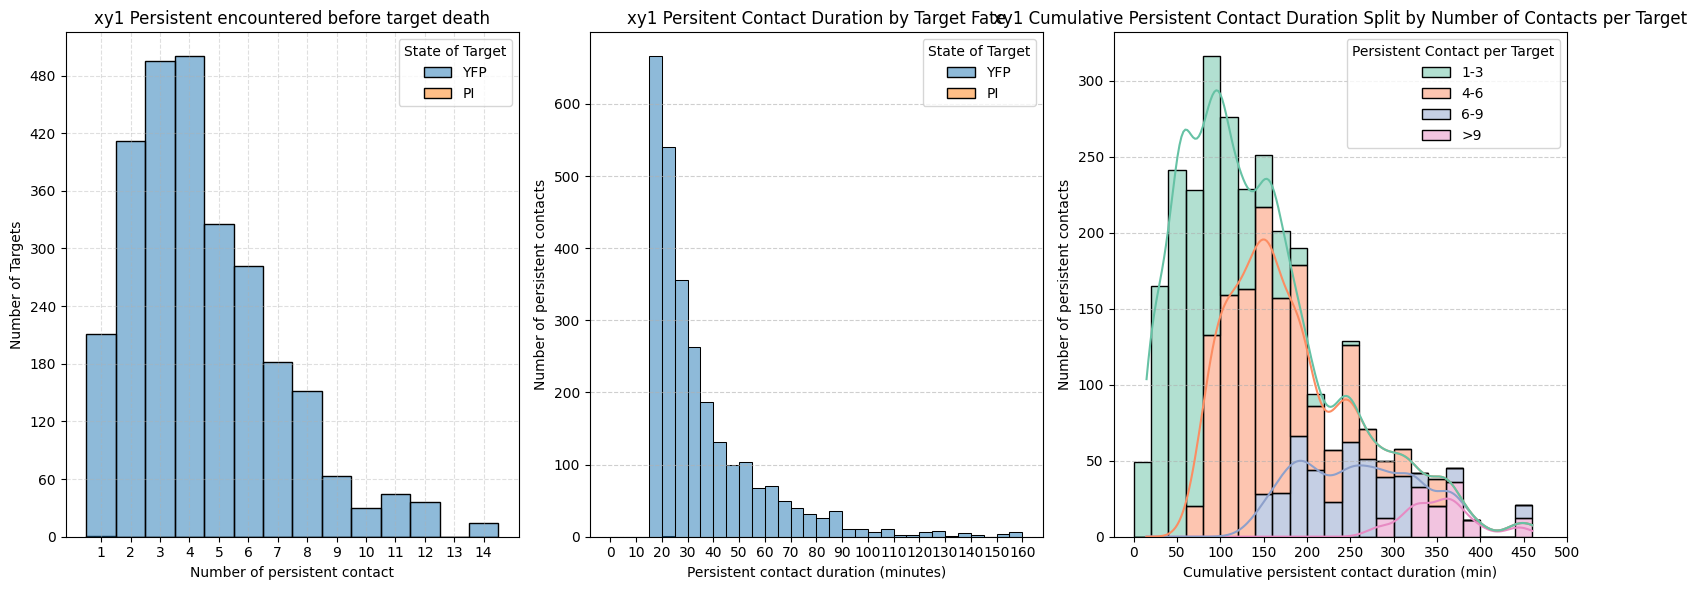

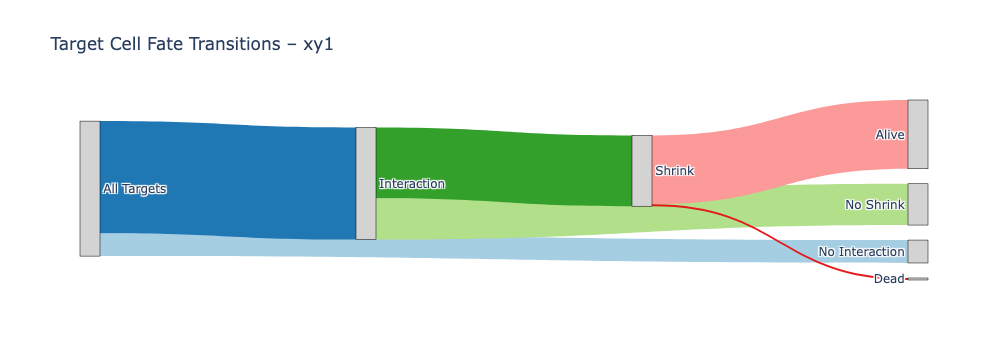

/tmp/ipykernel_67844/497626168.py:26: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



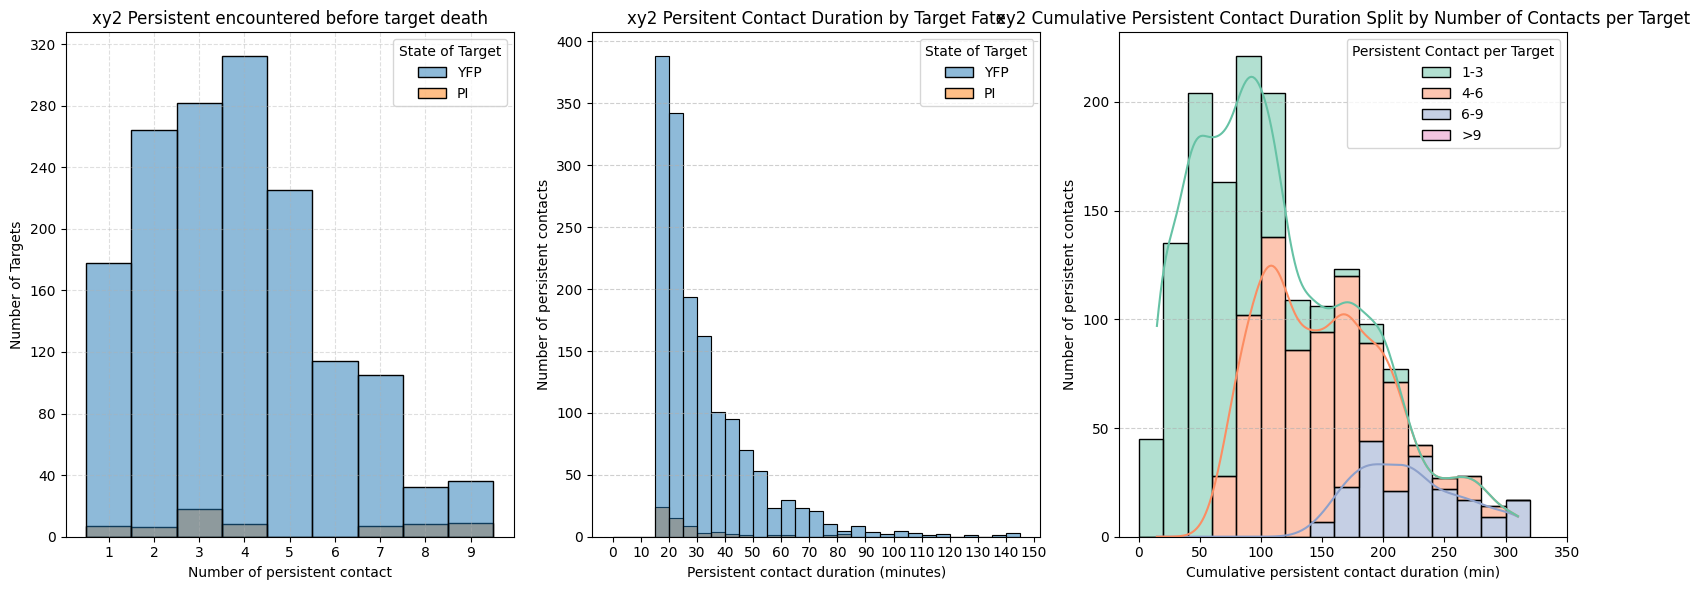

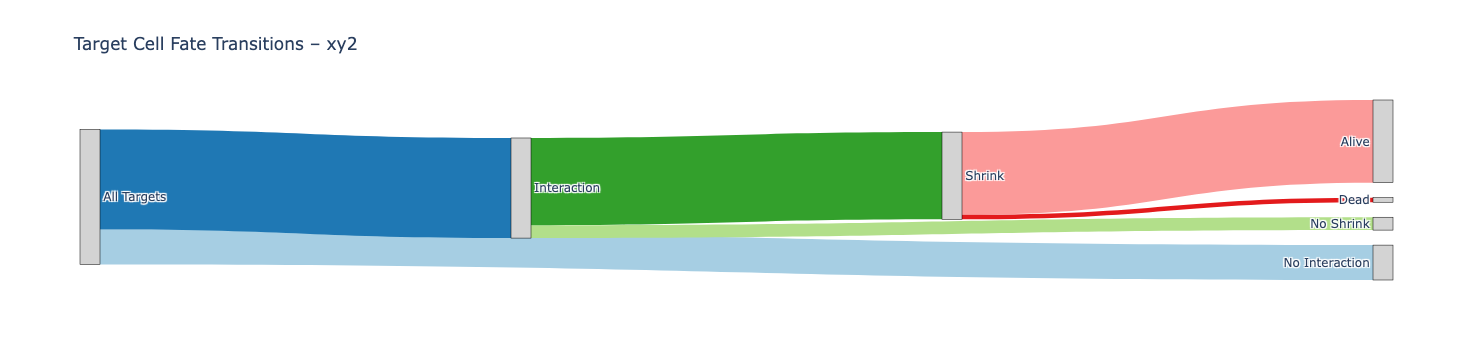

/tmp/ipykernel_67844/497626168.py:26: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



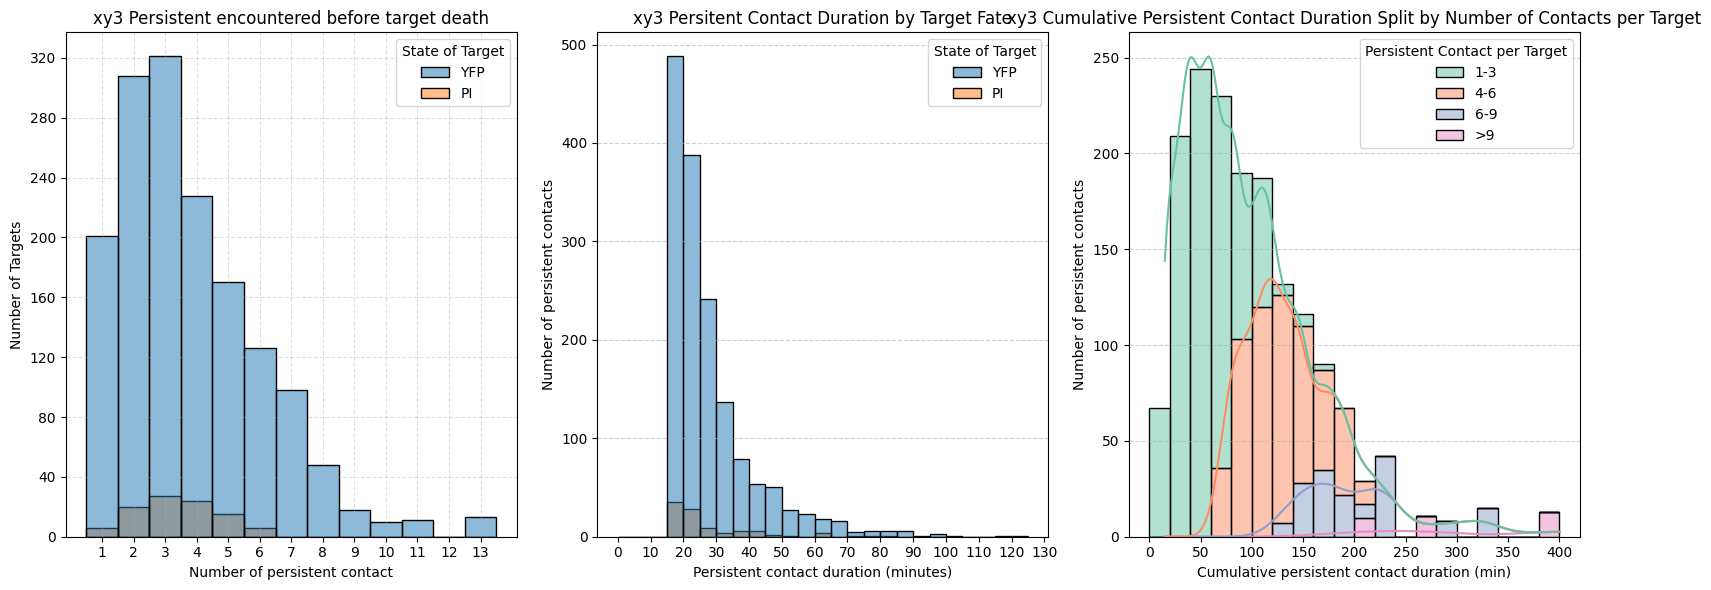

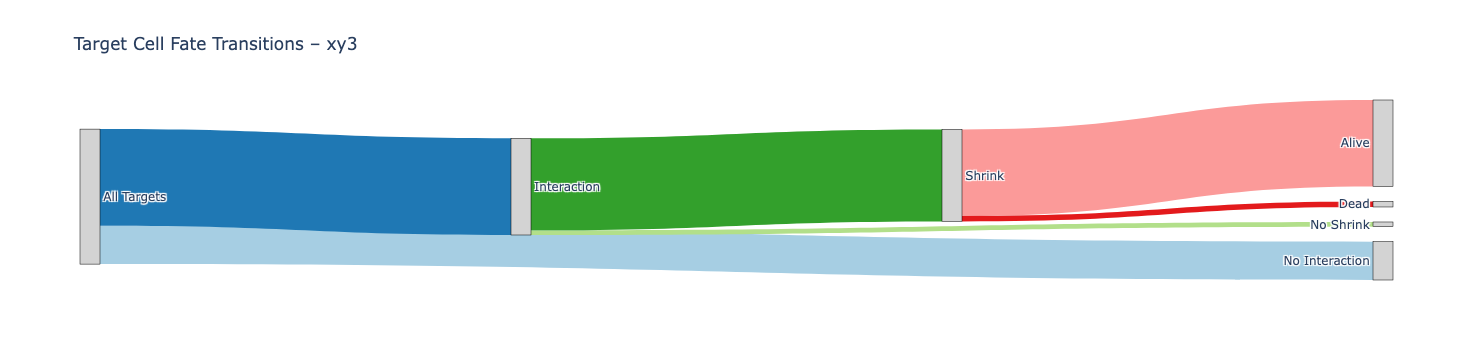

/tmp/ipykernel_67844/497626168.py:26: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



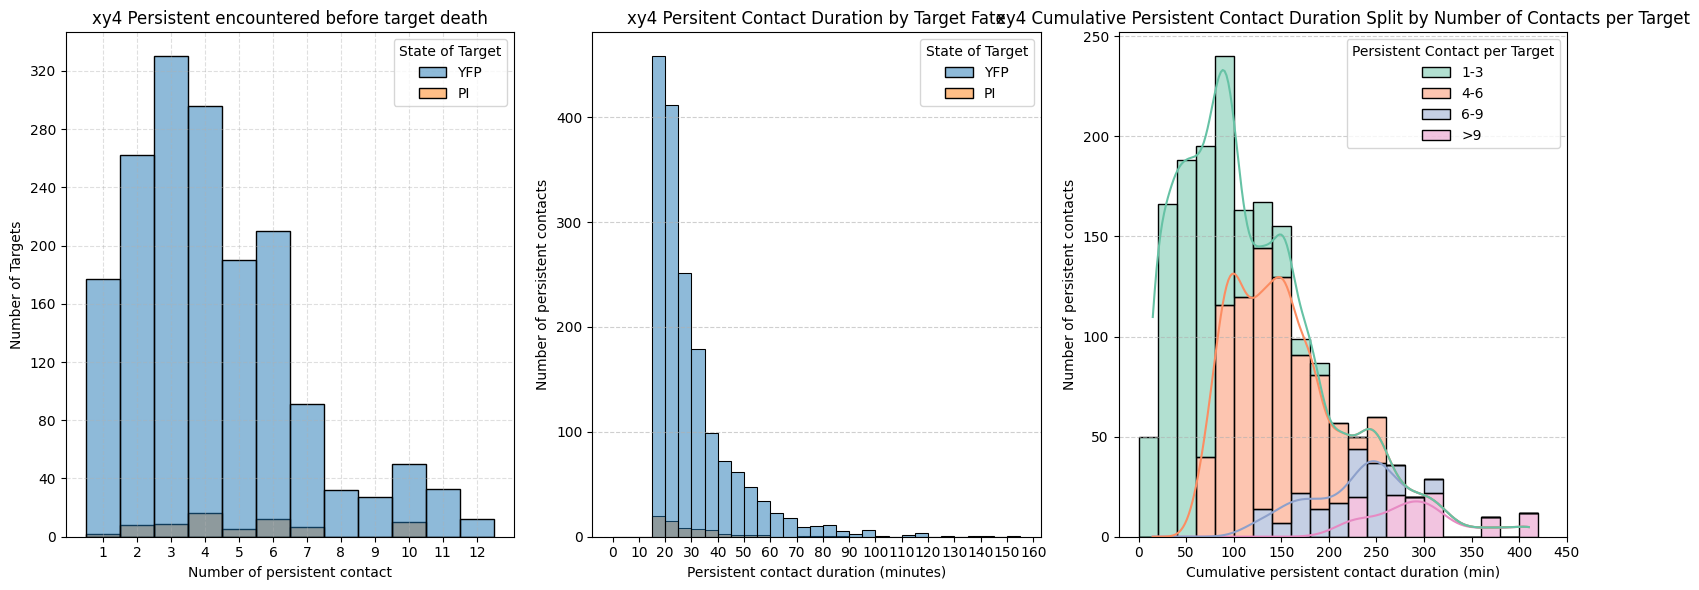

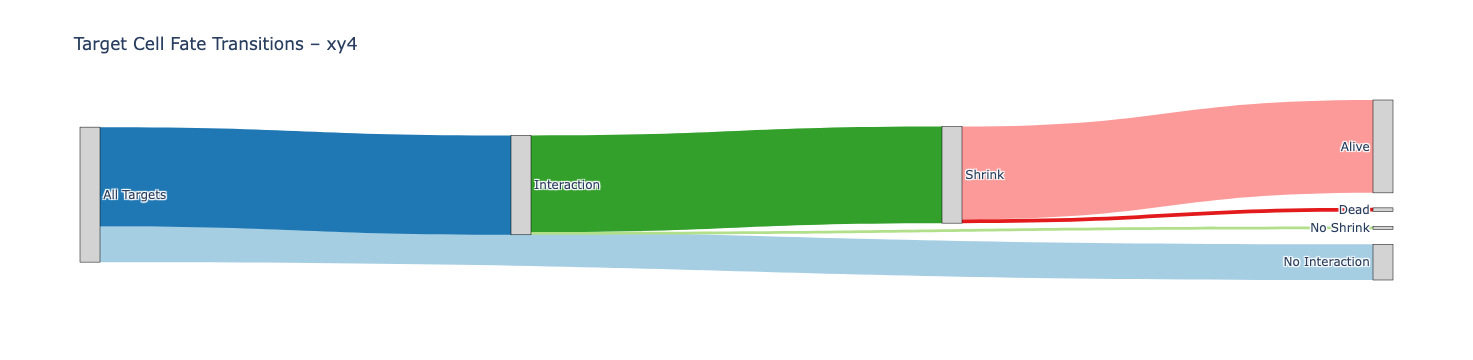

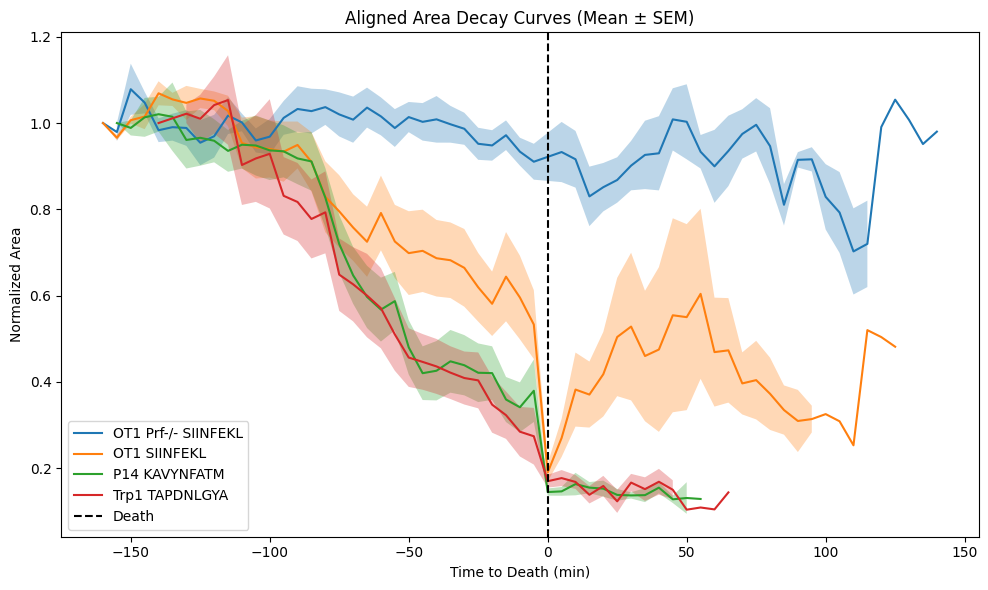

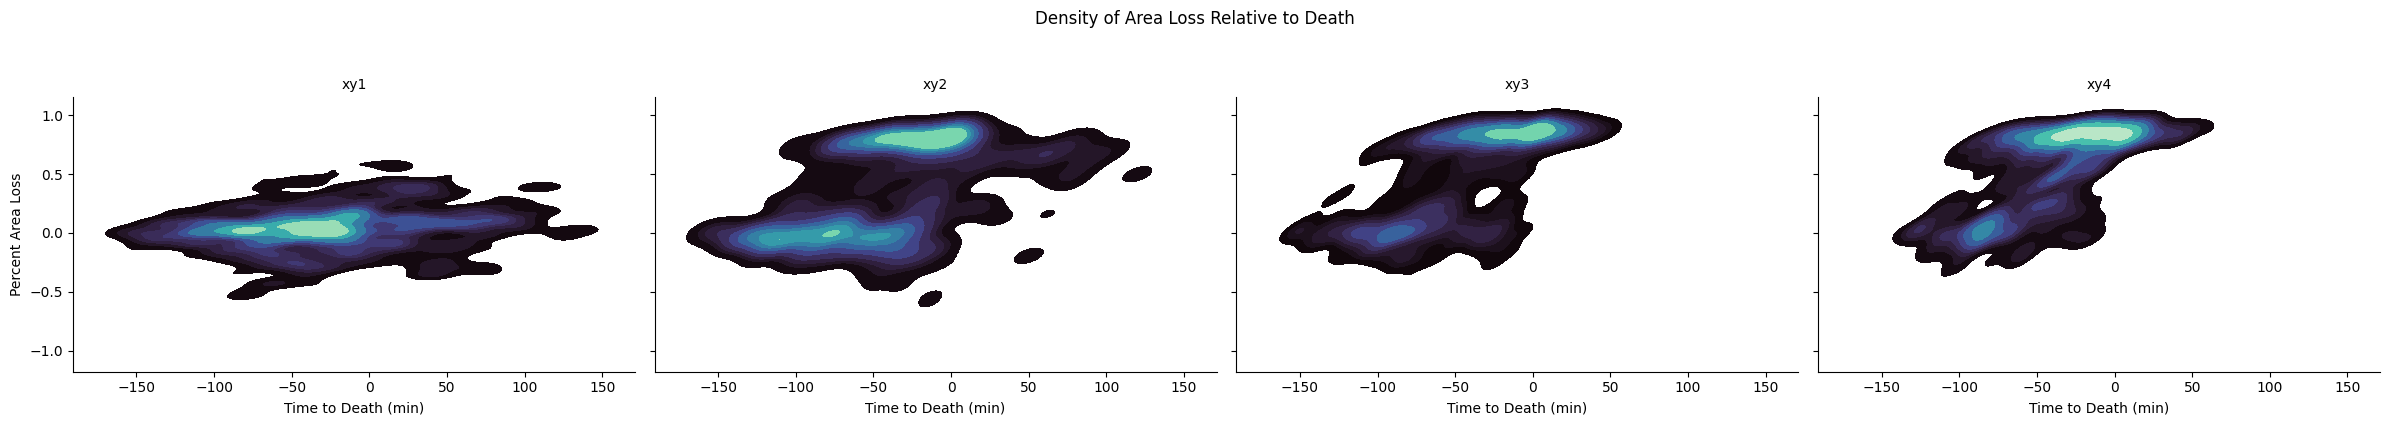

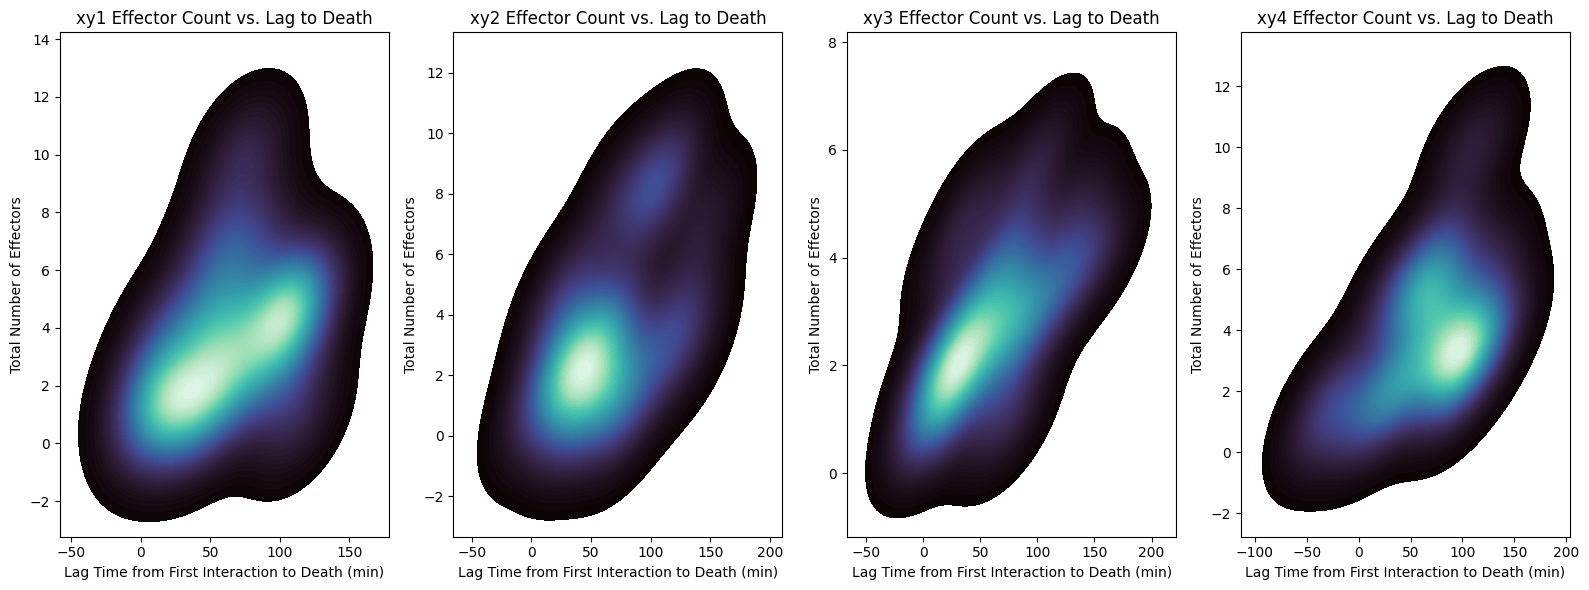

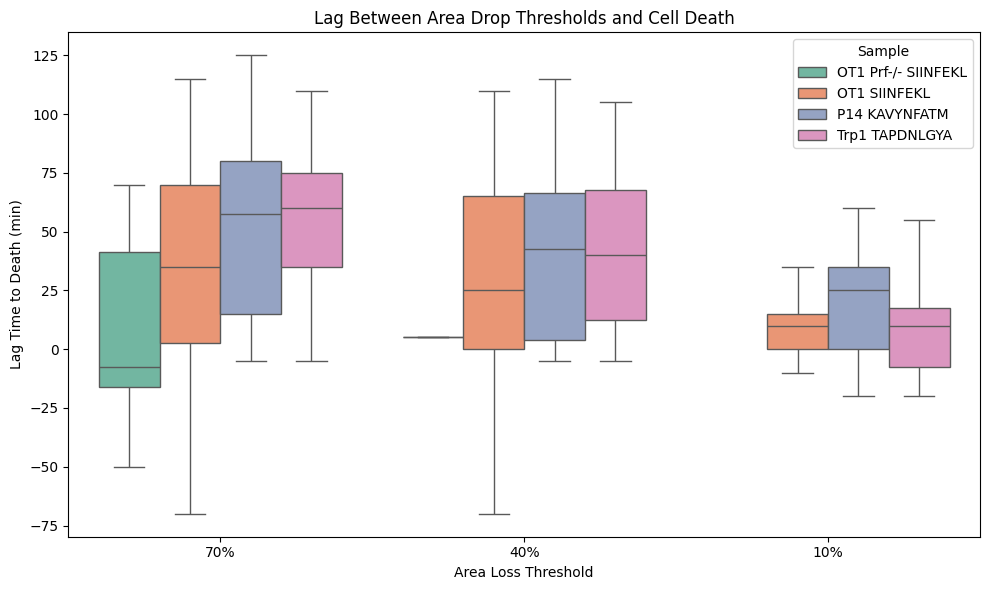

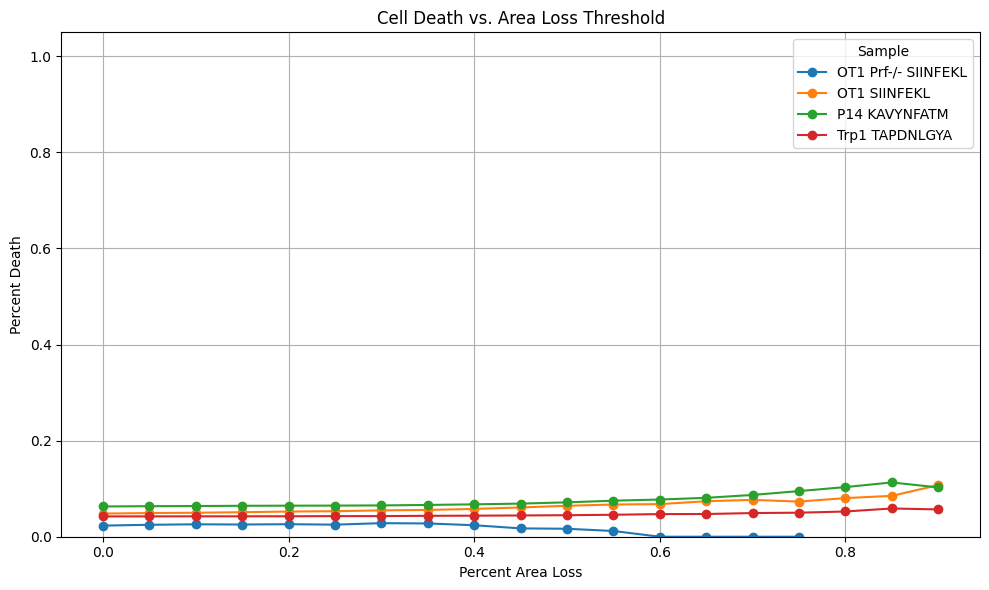

In [22]:
# Batch plot persistent encounter data
master_folder = '/home/vil945/live_cell_imaging/2025-04-30_live_cell_imaging'
# Provide a dictionary for mapping the sample code names to display names
sample_display_names = {
    'xy1': 'OT1 Prf-/- SIINFEKL',
    'xy2': 'OT1 SIINFEKL',
    'xy3': 'P14 KAVYNFATM',
    'xy4': 'Trp1 TAPDNLGYA'
}

# DO NOT change anything beyond this line
# Create folder for saving figures
fig_folder = os.path.join(master_folder, "figures")
os.makedirs(fig_folder, exist_ok=True)

# Recursively go through subfolders within master_folder
distance_csv = []
metrics_csv = []

tracking_found = False
for root, dirs, files in os.walk(master_folder):
    path = Path(root)
    # Calculations from TrackMate data should be saved in folders that contain "tracking" in the name
    if not tracking_found and "tracking" in path.name:
        distance_csv = list(path.rglob("*.csv"))
        tracking_found = True
    if "measurements" in path.name:
        metrics_csv.extend(path.glob("*.csv"))
    
# Match triplets of target_spots.csv, persistent_contact.csv, metrics.csv by matching index i within their file names containing "xy[i]"

# Dictionaries: key = index i, value = file path
target_files = {}
persistent_files = {}
metrics_files = {}

for f in distance_csv:
    target_match = re.search(r'xy(\d+)_target', f.name)
    persistent_match = re.search(r'xy(\d+)_persistent', f.name)
    if target_match:
        idx = target_match.group(1)
        target_files[idx] = f
    if persistent_match:
        idx = persistent_match.group(1)
        persistent_files[idx] = f
for f in metrics_csv:
    metrics_match = re.search(r'xy(\d+)_dual_channel', f.name)
    if metrics_match:
        idx = metrics_match.group(1)
        metrics_files[idx] = f

matched_indices = sorted(set(target_files.keys()) & set(persistent_files.keys()) & set(metrics_files.keys()))
combined_persistent = []
combined_metrics = []

for i in matched_indices:
    target_file = target_files[i]
    persistent_file = persistent_files[i]
    metrics_file = metrics_files[i]
    sample_idx = re.findall(r'xy(\d+)', str(target_file))

    # Load DataFrames
    target_df = pd.read_csv(target_file)
    persistent_df = pd.read_csv(persistent_file)
    metrics_df = pd.read_csv(metrics_file)

    # Pre-processing
    persistent_df, combined_persistent, filtered_metrics_df, combined_metrics = indv_df_preprocessing(sample_idx, persistent_df, combined_persistent, metrics_df, combined_metrics, frame_interval=5, dead_only=False)
    combined_metrics_df, combined_metrics_dying, combined_persistent_df = combined_df_preprocessing(combined_metrics, combined_persistent)

    # Plot histograms of interaction distribution
    plot_histogram_interaction_distribution(sample_idx[-1], persistent_df, fig_folder)
    # Plot interaction heatmap
    # plot_interaction_heatmap(persistent_df, filtered_metrics_df)
    # Plot metrics heatmap
    # plot_metrics_heatmap(filtered_metrics_df)
    # Plot Sankey plot
    plot_sankey(sample_idx[-1], target_df, filtered_metrics_df, fig_folder, shrink_threshold=0.7)


# Plot area decay curves
lag_df = plot_area_decay(combined_metrics_dying, sample_display_names, fig_folder, drop_step = 0.3)
# Plot area decay vs. lag time
plot_area_loss_vs_lag(combined_metrics_dying)
# Plot interaction count vs. lag time
plot_panel_interaction_vs_lag(combined_persistent_df, fig_folder)
# Plot box plot for lag time distribution
plot_lag_time_box_plot(lag_df, sample_display_names, fig_folder)
# Plot death probability vs. area decay
plot_death_fraction_vs_area_drop(combined_metrics_df, sample_display_names, fig_folder)